# Stochastic Optimization Example

We use the following model to generate synthetic stochastic optimization updates that transition from a transient phase to a stationary phase.

$$
x_t = x_* + a(t)\,v + z_t,
\quad
a(t)=\left(\frac{t_0}{t+t_0}\right)^\alpha,
\quad
z_t = \rho z_{t-1} + \sigma\,\epsilon_t,\ 
\epsilon_t\sim\mathcal{N}(0,I).
$$

Here, $x_*$ denotes the optimum point of the optimization, while the term $a(t)\,v$ captures the non-stationary transient phase, with $t_0$ and $\alpha$ controlling how quickly the iterates approach stationarity. The stochastic component $z_t$ models the osillations around the optimum $x_*$ through an AR(1) process, where $\rho$ controls the autocorrelation and $\sigma$ controls the noise scale.


In [2]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import seaborn as sns
from swasd import swasd
from swasd.plotting import (
    swd_comparison_plot,
    regression_diagnostic_plot,
    convergence_plot,
    trace_plot,
)
import nest_asyncio

nest_asyncio.apply()
np.set_printoptions(precision=3, suppress=True)

sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2})
sns.set_palette('colorblind', n_colors=30)
sns.set_style("ticks", {"axes.spines.right": False,
        "axes.spines.top": False})


In [4]:
def generate_optim_iterates_simple(
    steps: int = 50000,
    d: int = 5,
    seed: int = 0,
    *,
    x_star=None,
    t0: float = 450.0,
    alpha: float = 0.99,
    rho: float = 0.99,
    sigma: float = 2.5e-4,
    v=None,
):
    rng = np.random.default_rng(seed)

    if x_star is None:
        x_star = np.zeros(d)
    else:
        x_star = np.asarray(x_star, float)

    if v is None:
        v = rng.normal(size=d)
        v = v / (np.linalg.norm(v) + 1e-12) * 2.0  # initial offset magnitude
    else:
        v = np.asarray(v, float)

    z = np.zeros(d)
    X = np.empty((steps, d), float)

    for t in range(steps):
        tt = t + 1
        a = (t0 / (tt + t0)) ** alpha
        z = rho * z + sigma * rng.normal(size=d)
        X[t] = x_star + a * v + z

    return X


Generate a (num_iters, num_dims) matrix of stochastic optimization iterates.

In [5]:
T = 50000
d = 5

X = generate_optim_iterates_simple(steps=T, d=d)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Parameter Value'>)

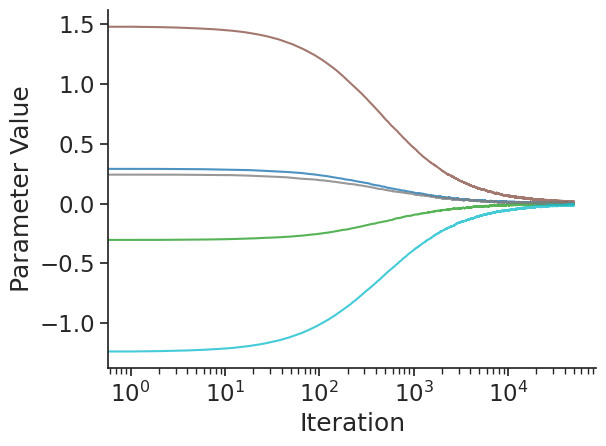

In [6]:
trace_plot(X, xlog=True)

We create a stationary sample to compare the estimated values of $\mathcal{SW}_{p,\Sigma}(\pi_{(i)},\pi)$, for $i=1,\ldots,B$ with the ground truth.

In [7]:
def sample_stationary_reference(n, d, x_star, rho, sigma, seed=0):
    rng = np.random.default_rng(seed)
    x_star = np.asarray(x_star, float)
    var = (sigma**2) / (1.0 - rho**2)
    return x_star[None, :] + rng.normal(size=(n, d)) * np.sqrt(var)

X_true = sample_stationary_reference(n=1000, d=d, x_star=np.zeros(d), rho=0.99, sigma=2.0e-4)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Parameter Value'>)

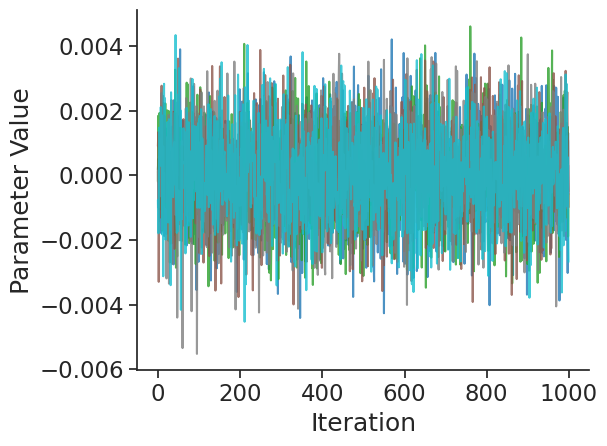

In [8]:
trace_plot(X_true, xlog=False)

Now we run the *SWASD* algorithm to detect convergence of the optimization iterates

In [9]:
results = swasd(X, true_swd=True, true_samples=X_true)

SWASD Convergence Detection:  98%|█████████▊| 41/42 [13:25<00:19, 19.65s/check, k=47962, rhat=3.044, SWD=2.666]


CONVERGENCE DETECTED!
Convergence at iteration: 47962
Detection method: SWD
Final SWD distance: 0.8419 (threshold: 1.0000)

Rhat checks performed: 22
Best Rhat achieved: 2.9910

SWD checks performed: 20
Initial SWD: 5.8973
Final SWD: 0.8419


In [10]:
#read the results at the convergence
swd_pairwise_convg_results =results['pairwise_swd_results'][-1]
swd_estimated_convg_results = results['estimated_swd_results'][-1]
swd_regression_convg_results = results['regression_results'][-1]
swd_true_convg_results = results['true_swd_results'][-1]

Next we can compare the observed pairwise distances with the fitted values at the convergence check point.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Block Pairs', ylabel='$\\mathrm{SWD}(\\hat{\\pi}_{(i)}, \\hat{\\pi}_{(j)})$'>)

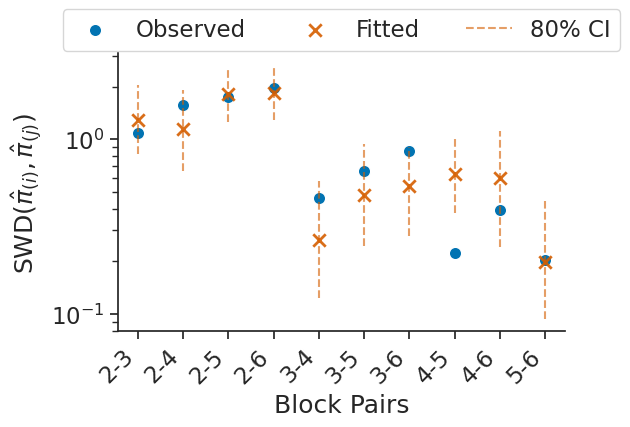

In [11]:
regression_diagnostic_plot(
            swd_pairwise_convg_results, swd_regression_convg_results)

The regression model fitted the pairwise sliced Wasserstein distances quite well. We can also compare the true and the estimated sliced Wasserstein distance between block distribution and stationary distribution $\mathcal{SW}_{2,\Sigma}(\pi_{(i)},\pi)$

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\mathrm{SWD}(\\pi_{(i)}, \\pi)$', ylabel='$\\widehat{\\mathrm{SWD}}(\\pi_{(i)}, \\pi)$'>)

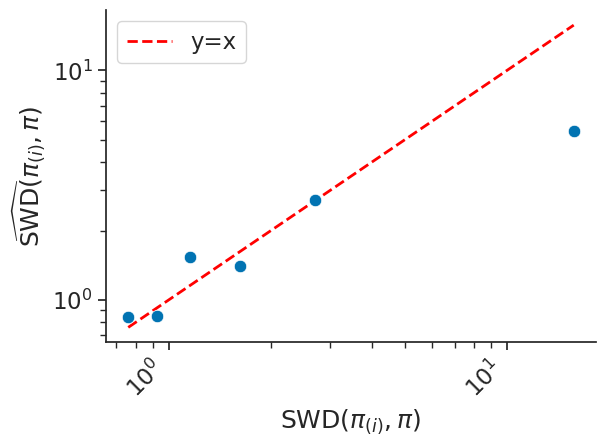

In [12]:
swd_comparison_plot(swd_estimated_convg_results, swd_true_convg_results,
                    xlog=True, ylog=True)

We can check the reliability of $\widehat{\mathcal{SW}}_{2,\Sigma}(\pi_{(i)},\pi)$ by comparing it with its true values $\mathcal{SW}_{2,\Sigma}(\pi_{(i)},\pi)$.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Diagnostic Value'>)

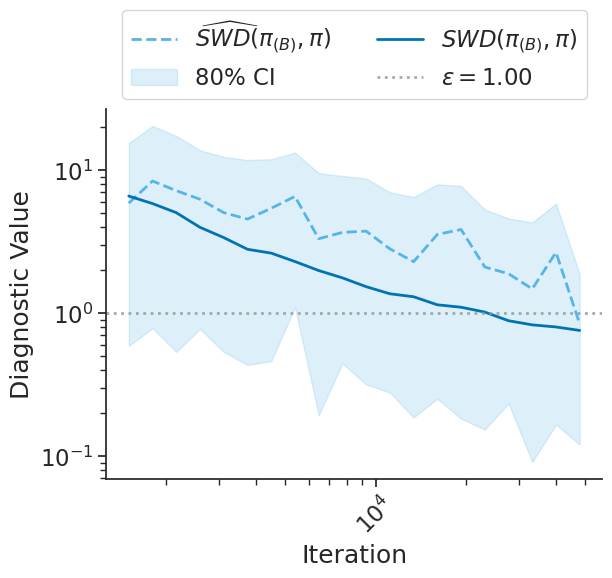

In [13]:
convergence_plot(results, xlog=True, ylog=True)